In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location

In [3]:
import datetime

In [4]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2022-02-16_17-24-33'

In [5]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp

In [6]:
ensure_dir(filename_prefix)

### Get camera information

In [7]:
!k4arecorder --list

Index:0	Serial:000774310512	Color:1.6.102	Depth:1.6.75


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)

In [8]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [9]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            "synchronized_images_only": False,
            #"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
        },
    }
}

### Set up processing functions
- Functions for reducing video file sizes to 8 bit. 

In [63]:
_dtype = np.uint16

In [64]:
def process_depth(depth):
    #return np.clip((depth - 435) * (depth < 690), 0, 255).astype(_dtype)
    return depth.astype(_dtype)
def process_ir(ir):
    #ir = np.clip(ir + 100, 160, 5500)
    #return ((np.log(ir) - 5) * 70).astype(_dtype)
    return ir.astype(_dtype)

### Recording parameters

In [169]:
write_frames_kwargs={
        "codec": "ffv1",
        "crf": 14,
        "threads": 6,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [170]:
recording_duration = 5

### Run recording

In [189]:
start_recording(
    filename_prefix,
    recording_duration,
    devices=devices,
    depth_function = process_depth,
    ir_function = process_ir,
    video_dtype = _dtype,
    write_frames_kwargs=write_frames_kwargs
)

 - Frame rate =  30.700031063185367


In [190]:
filename_prefix

PosixPath('/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-16_17-24-33')

In [191]:
!ls /n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-16_17-24-33

master


In [215]:
import cv2

In [216]:
vidcap = cv2.VideoCapture((filename_prefix / 'master' /  "ir.avi").as_posix())
total_frames = vidcap.get(7)
print(total_frames)

148.0


In [217]:
success,image = vidcap.read()
# get frame at number
vidcap.set(1, 50)
success,image = vidcap.read()

<ipython-input-218-7e66175de1ce>:2: RuntimeWarning: divide by zero encountered in log
  ax.matshow(np.log(1+frame)[:,:,0])


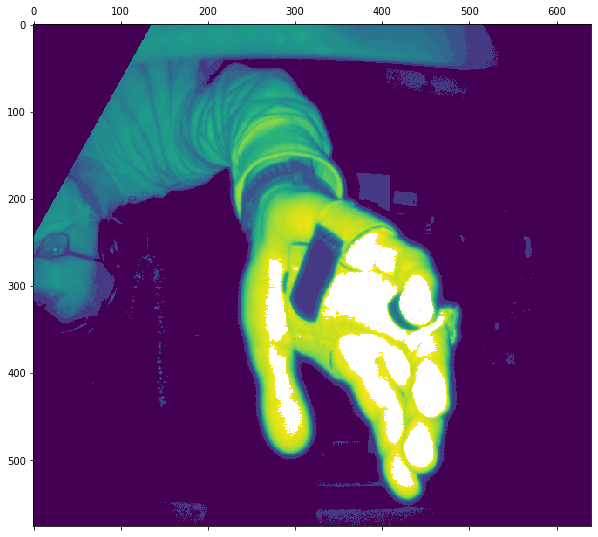

In [218]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.log(1+frame)[:,:,0])